# Feature Enhancement 特征增强

清洗数据

## 导入数据

引入皮马印第安人糖尿病预测数据集

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10.0, 4.0) # 设置figure_size尺寸
plt.rcParams['image.interpolation'] = 'nearest' # 设置 interpolation style
plt.rcParams['image.cmap'] = 'gray' # 设置 颜色 style
plt.rcParams['savefig.dpi'] = 100 #图片像素
plt.rcParams['figure.dpi'] = 100 #分辨率

In [2]:
pima_columns = ['times_pregment','plasma_glucose_concentration','diastolic_blood_pressure','triceps_thickness',
                'serum_insulin','bmi','pedigree_function','age','onset_disbetes']

pima = pd.read_csv('./data/pima.data', names=pima_columns)
pima.head()

,times_pregment,plasma_glucose_concentration,diastolic_blood_pressure,triceps_thickness,serum_insulin,bmi,pedigree_function,age,onset_disbetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
pima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
times_pregment                  768 non-null int64
plasma_glucose_concentration    768 non-null int64
diastolic_blood_pressure        768 non-null int64
triceps_thickness               768 non-null int64
serum_insulin                   768 non-null int64
bmi                             768 non-null float64
pedigree_function               768 non-null float64
age                             768 non-null int64
onset_disbetes                  768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
# 查看字段的基本统计情况
pima.describe()

,times_pregment,plasma_glucose_concentration,diastolic_blood_pressure,triceps_thickness,serum_insulin,bmi,pedigree_function,age,onset_disbetes
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## 缺失值处理

### 操作单列

In [5]:
# 处理被错误填充的缺失值 0，还原为 None(单独处理)
pima['serum_insulin'] = pima['serum_insulin'].map(lambda x:x if x !=0 else None)

# 检查变量缺失情况
pima['serum_insulin'].isnull().sum()

374

### 批量操作多列

In [6]:
# 需要操作的列
columns = ['serum_insulin','bmi','plasma_glucose_concentration','diastolic_blood_pressure','triceps_thickness']

# 遍历替换 缺失值 0 为 None
for col in columns:
    pima[col].replace([0], [None], inplace=True)

# 检查变量缺失情况
pima.isnull().sum()

times_pregment                    0
plasma_glucose_concentration      5
diastolic_blood_pressure         35
triceps_thickness               227
serum_insulin                   374
bmi                              11
pedigree_function                 0
age                               0
onset_disbetes                    0
dtype: int64

### 删除含有缺失值的行

In [7]:
pima_dropped = pima.dropna()

# 查看删除后有多少行
num_rows_lost = round(100*((pima.shape[0]-pima_dropped.shape[0])/pima.shape[0]))
print("保留了原先 {}% 的行".format(num_rows_lost))

保留了原先 49% 的行


Text(0, 0.5, '% change')

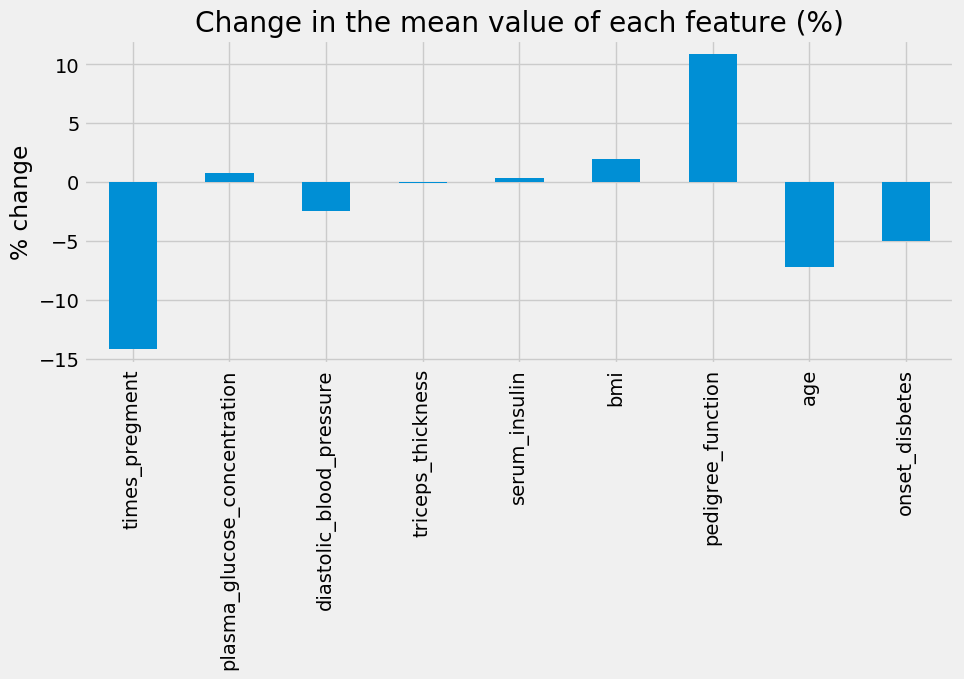

In [8]:
# 查看下删除行之后，各个特征均值的差异
ax = (100*(pima_dropped.mean()-pima.mean())/pima.mean()).plot(kind='bar', title='Change in the mean value of each feature (%)')
ax.set_ylabel('% change')

### 使用 Sklearn 填充缺失值

使用sklearn 的 Pipeline 以及 Imputer 来实现缺失值填充。

用均值填充。

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 以一个 KNN 模型为例
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# 调参候选
knn_params = {'classify__n_neighbors':[1, 2, 3, 4, 5, 6]}

# 实例化KNN模型
knn = KNeighborsClassifier()

# 管道设计
mean_impute = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                        ('classify', knn)])

x = pima.drop('onset_disbetes', axis=1) # 丢弃y
y = pima['onset_disbetes']

# 网格搜索
grid = GridSearchCV(mean_impute, knn_params)
grid.fit(x, y)

# 打印模型效果
print(grid.best_score_, grid.best_params_)

E:\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7317708333333334 {'classify__n_neighbors': 6}


## 标准化与归一化

In [10]:
impute = SimpleImputer(strategy='mean')
pima_imputed_mean = pd.DataFrame(impute.fit_transform(pima),columns=pima_columns)
pima_imputed_mean.head()

,times_pregment,plasma_glucose_concentration,diastolic_blood_pressure,triceps_thickness,serum_insulin,bmi,pedigree_function,age,onset_disbetes
0,6.0,148.0,72.0,35.00000,155.548223,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.00000,155.548223,26.6,0.351,31.0,0.0
2,8.0,183.0,64.0,29.15342,155.548223,23.3,0.672,32.0,1.0
3,1.0,89.0,66.0,23.00000,94.000000,28.1,0.167,21.0,0.0
4,0.0,137.0,40.0,35.00000,168.000000,43.1,2.288,33.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B15CD64C08>,
      dtype=object)

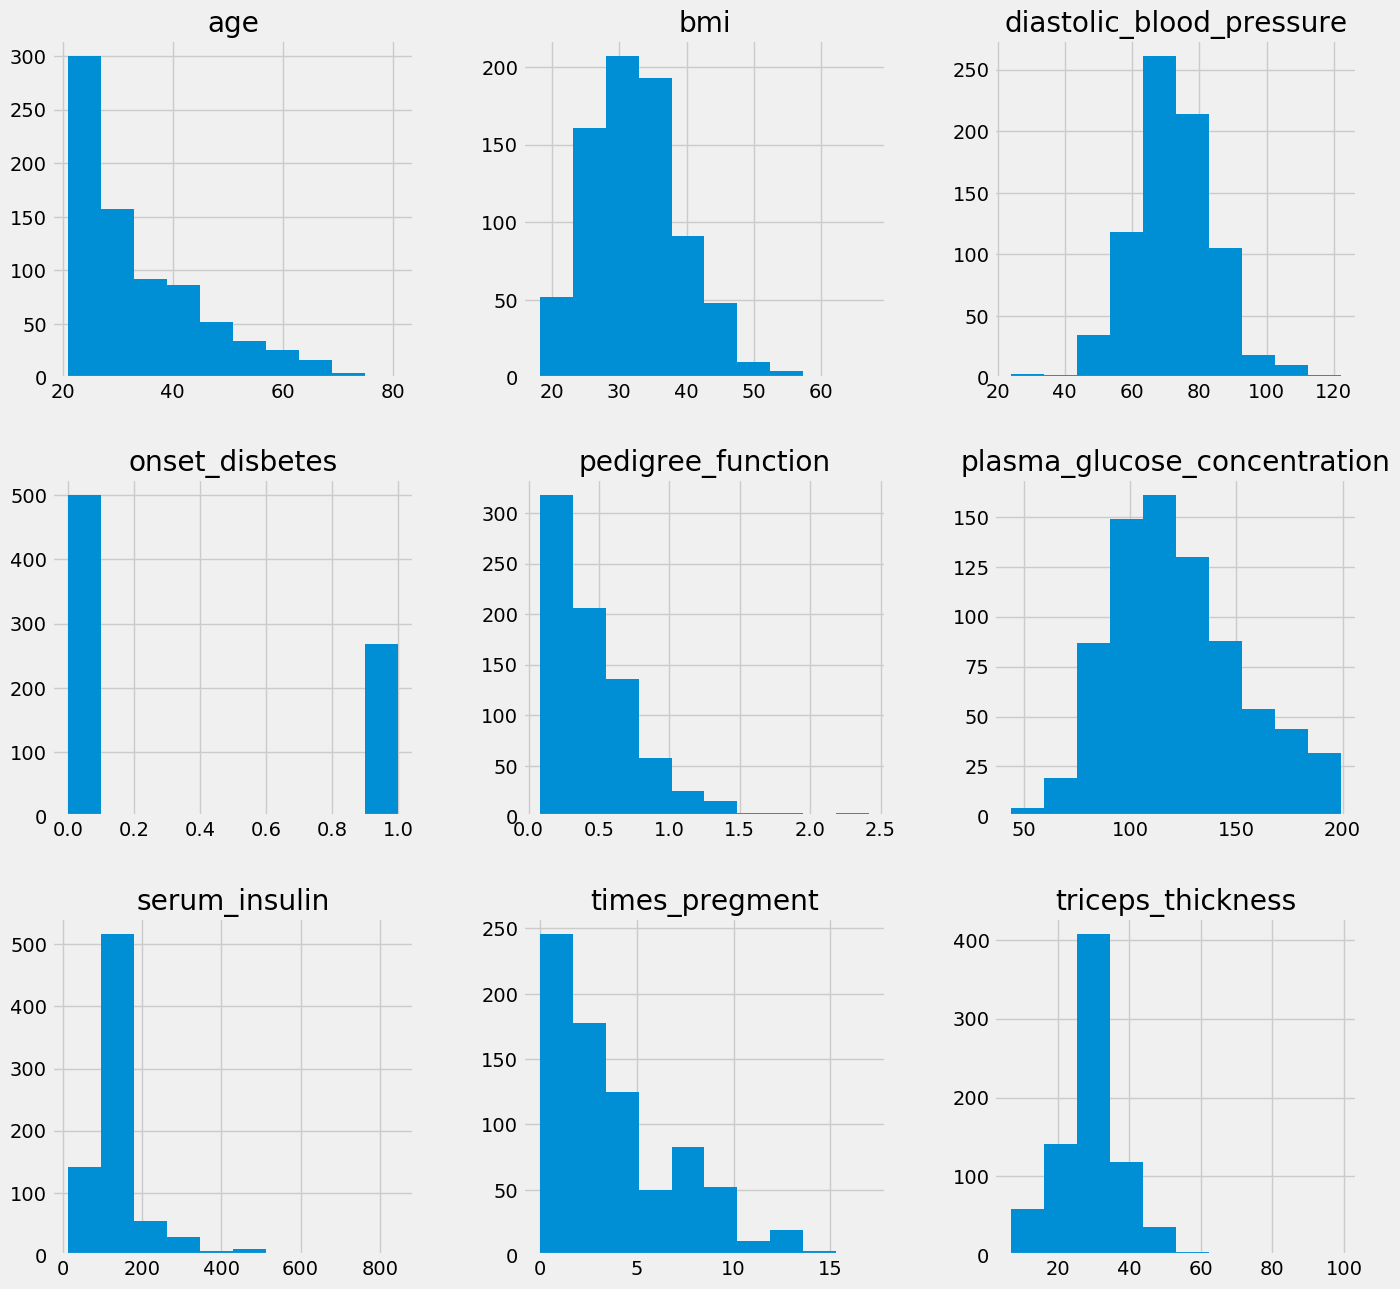

In [11]:
pima_imputed_mean.hist(figsize=(15,15))

### z 分数标准化

#### 单一特征 z 分数标准化

In [12]:
from sklearn.preprocessing import StandardScaler

# 实例化方法
scaler = StandardScaler()
glucose_z_score_standarScaler = scaler.fit_transform(pima[['plasma_glucose_concentration']].fillna(-9))

# 看看转换之后的均值和标准差是否为0和1
glucose_z_score_standarScaler.mean(), glucose_z_score_standarScaler.std()

(-9.25185853854297e-18, 1.0)

#### 全部特征 z 分数标准化

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B160544848>,
      dtype=object)

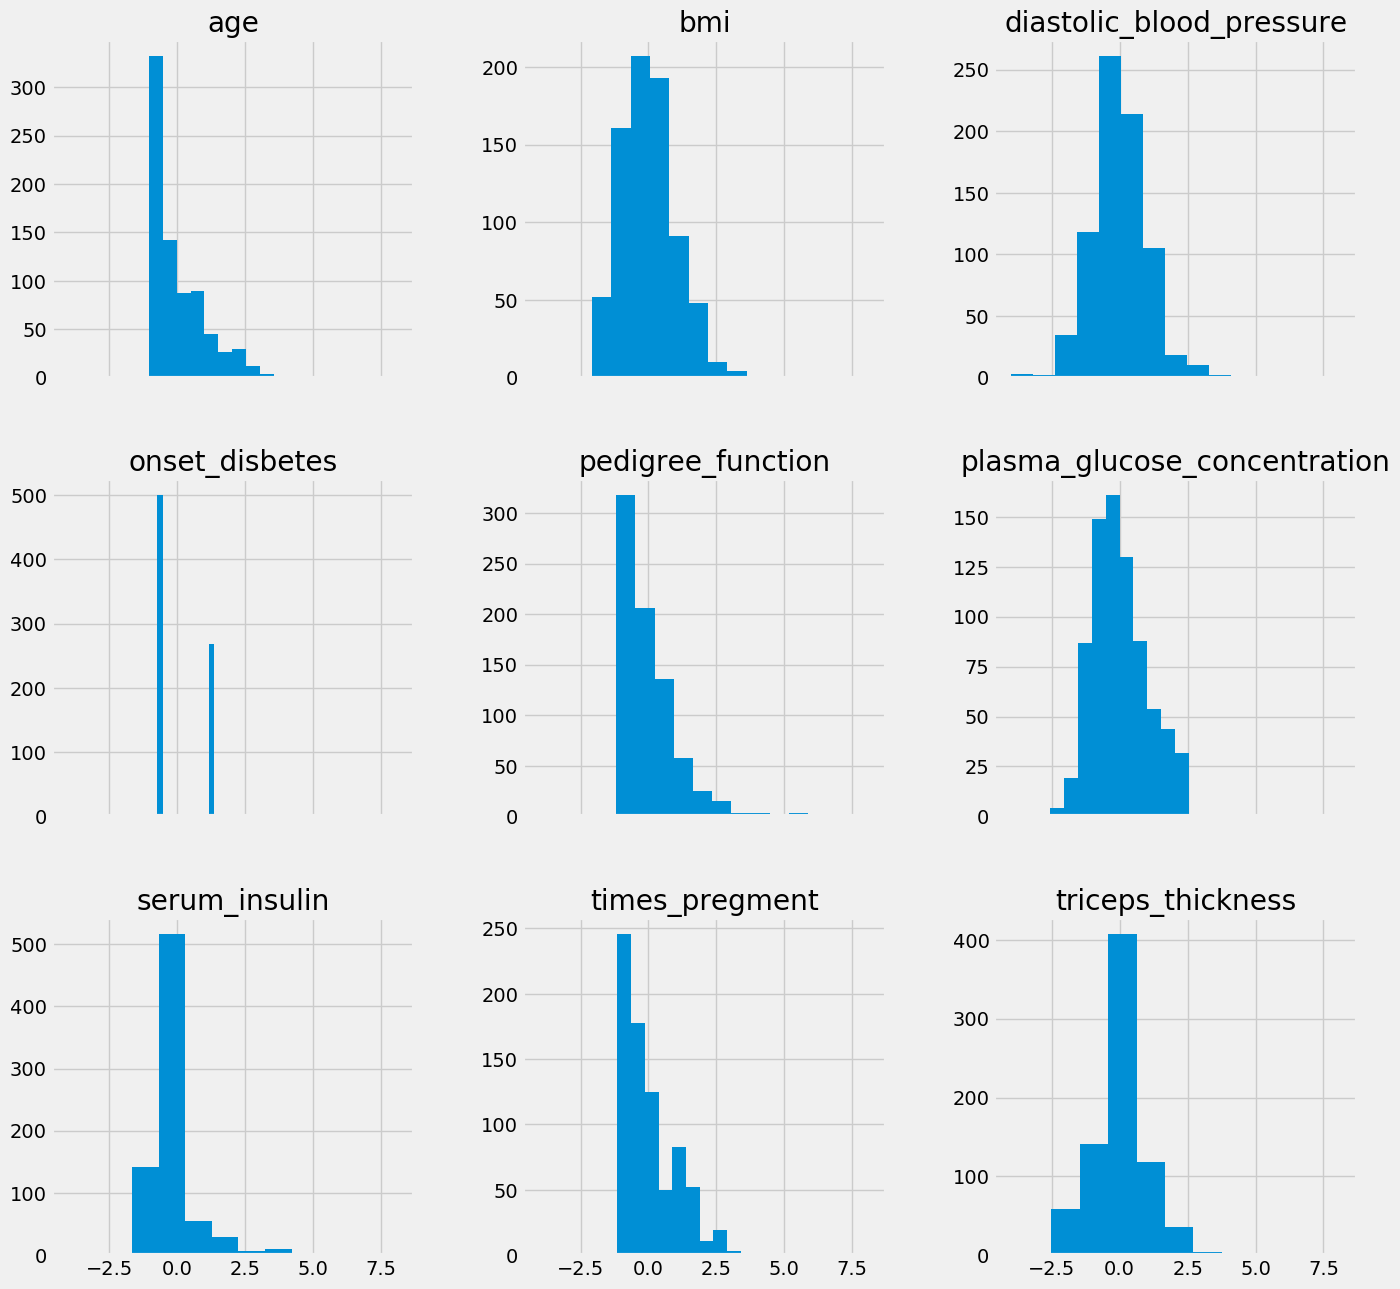

In [13]:
from sklearn.preprocessing import StandardScaler

# 实例化方法
scaler = StandardScaler()
pima_imputed_mean_scaled = pd.DataFrame(scaler.fit_transform(pima_imputed_mean), columns=pima_columns)

# 看下标准化之后的分布
pima_imputed_mean_scaled.hist(figsize=(15,15), sharex=True)

### min-max标准化

In [14]:
from sklearn.preprocessing import MinMaxScaler

# 实例化方法
min_max = MinMaxScaler()
# 使用min-max标准化
pima_min_maxed = pd.DataFrame(min_max.fit_transform(pima.fillna(-9)), columns=pima_columns)

### 行归一化

In [15]:
from sklearn.preprocessing import Normalizer

# 实例化方法
normalize = Normalizer()
# 使用行归一化
pima_normalized = pd.DataFrame(normalize.fit_transform(pima.fillna(-9)), columns=pima_columns)

# 查看矩阵的平均范数
np.sqrt((pima_normalized**2).sum(axis=1)).mean()

1.0